# Procesamiento Digital de Señales <img src="./logo_UTN.svg" align="right" width="150"/>
## Alumno: Emanuel Olay
### Tarea Semanal: 4
### Consigna:
En esta tarea semanal retomamos la consigna de la tarea anterior, donde simulamos el bloque de cuantización de un ADC de B bits en un rango de  ±VF Volts. Ahora vamos a completar la simulación del ADC incluyendo la capacidad de muestrear a fs Hertz.

Para ello se simulará el comportamiento del dispositivo al digitalizar una senoidal contaminada con un nivel predeterminado de ruido. Comenzaremos describiendo los parámetros a ajustar de la senoidal:

frecuencia $f_0$ arbitraria, por ejemplo $f_0=f_S/N=Δf$ 
energía normalizada, es decir energía (o varianza) unitaria
Con respecto a los parámetros de la secuencia de ruido, diremos que:

será de carácter aditivo, es decir la señal que entra al ADC será $s_R=s+n$. Siendo n la secuencia que simula la interferencia, y s la senoidal descrita anteriormente.
La potencia del ruido será Pn=kn.Pq W siendo el factor k una escala para la potencia del ruido de cuantización $Pq=q^2/12$.
finalmente, n será incorrelado y Gaussiano.
El ADC que deseamos simular trabajará a una frecuencia de muestreo $f_S=1000 Hz$ y tendrá un rango analógico de $±V_F=2 Volts$.

Se pide:

a) Generar el siguiente resultado producto de la experimentación. B = 4 bits, kn=1.

In [33]:
#######################################################################################################################
#%% Configuración e inicio de la simulación
#######################################################################################################################
import warnings
warnings.filterwarnings('ignore')


import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
from scipy.fft import fft

width=15
height=5
plt.rcParams['figure.figsize'] = [width, height]

# Datos generales de la simulación
fs = 1000 # frecuencia de muestreo (Hz)
N = 1000   # cantidad de muestras
 
# cantidad de veces más densa que se supone la grilla temporal para tiempo "continuo"
over_sampling = 4
N_os = N*over_sampling
 
# Datos del ADC
B = 4 # bits
Vf = 2 # Volts
q = Vf/2**B # Volts
 
# datos del ruido
kn = 1
pot_ruido = q**2/12 * kn # Watts (potencia de la señal 1 W)
 
ts = 1/fs # tiempo de muestreo
df = fs/N # resolución espectral

f=np.arange(0,fs,fs/N)
f_os=np.arange(0,fs,fs/N_os)

In [34]:
#######################################################################################################################
#%% Acá arranca la simulación
 #%% Cuentas correspondientes al seno ideal
t = np.linspace(0, 1, N_os,endpoint=False)
t_samp=np.arange(0,1,ts)
#senoidal de amplitud 1 y 1 hz de frecuencia
amp=1 #amplitud en volts
freq=1 #fs/N #frecuencia en Hz
fase=0 #radianes
##Armo el seno ideal
analog_sig=amp*np.sin(2 * np.pi * freq * t + fase)
##calculo su potencia en watts
seno_ideal_watts = analog_sig ** 2
##Calculo potencia en dB
seno_ideal_db = 10 * np.log10(seno_ideal_watts)
    #%% Cuentas correspondientes al ruido

##Armo el ruido con la potencia calculada
noise = np.random.normal(0, np.sqrt(pot_ruido), len(seno_ideal_watts))
    #%%Le sumo el ruido al seno ideal
sr_1 = analog_sig + noise

    #%%Cuantizacion
sr=sr_1[::over_sampling]
srq=np.round(sr/q)*q
    #%%Normalizo la señal para hacer
##Calculo la potencia
E0=1/N*sum(np.abs(analog_sig)**2)
#print("Potencia del seno cont0=",E0)
E1=1/N*sum(np.abs(sr)**2)
#print("Potencia del seno cont1=",E1)
E2=1/N*sum(np.abs(srq)**2)
#print("Potencia del seno cont2=",E2)

analog_sig_norm=analog_sig/np.sqrt(E0)
#print("Potencia normalizada 1=",np.var(sin_nom0))
sr_norm=sr/np.sqrt(E1)
#print("Potencia normalizada 2=",np.var(sin_nom1))
srq_norm=srq/np.sqrt(E2)
#print("Potencia normalizada 3=",np.var(sin_nom2))
    #%%Calculo de la Densidad espectral de potencia
DEP_srq=np.abs(1/N*fft(srq_norm))**2
DEP_sr=np.abs(1/N*fft(sr_norm))**2
DEP_analog_sig=np.abs(1/N*fft(analog_sig_norm))**2
Noise_q=sr-srq
Noise_q_mean=np.mean(Noise_q)
Noise_mean=np.mean(noise)

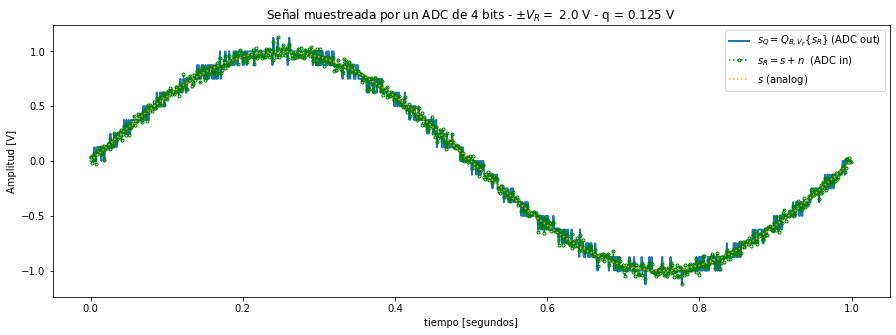

In [35]:
#######################################################################################################################
#%% Presentación gráfica de los resultados
plt.close('all')
 
plt.figure(1)
plt.plot(t_samp, srq, lw=2, label='$ s_Q = Q_{B,V_F}\{s_R\} $ (ADC out)')
plt.plot(t_samp, sr, linestyle=':', color='green',marker='o', markersize=3, markerfacecolor='none', markeredgecolor='green', fillstyle='none', label='$ s_R = s + n $  (ADC in)')
plt.plot(t, analog_sig, color='orange', ls='dotted', label='$ s $ (analog)')
 
plt.title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q) )
plt.xlabel('tiempo [segundos]')
plt.ylabel('Amplitud [V]')
axes_hdl = plt.gca()
axes_hdl.legend()

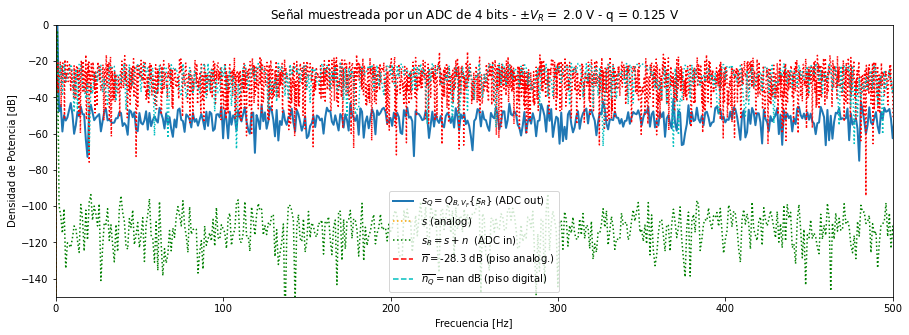

In [36]:
####################################################

plt.figure(2)
plt.plot( f, 10* np.log10(2*DEP_srq), lw=2, label='$ s_Q = Q_{B,V_F}\{s_R\} $ (ADC out)' )
plt.plot( f_os, 10* np.log10(2*DEP_analog_sig**2), color='orange', ls='dotted', label='$ s $ (analog)' )
plt.plot( f, 10* np.log10(2*DEP_sr**2), ':g', label='$ s_R = s + n $  (ADC in)' )
plt.plot( f_os, 10* np.log10(2*noise**2), ':r')
plt.plot( f, 10* np.log10(2*Noise_q**2), ':c')
plt.plot( np.array([ 0, 1 ]), 10* np.log10(2* np.array([Noise_mean, Noise_mean]) ), '--r', label= '$ \overline{n} = $' + '{:3.1f} dB (piso analog.)'.format(10* np.log10(2* Noise_mean)) )
plt.plot( np.array([ 0, 1 ]), 10* np.log10(2* np.array([Noise_q_mean, Noise_q_mean]) ), '--c', label='$ \overline{n_Q} = $' + '{:3.1f} dB (piso digital)'.format(10* np.log10(2* Noise_q_mean)) )

plt.title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q) )
plt.ylabel('Densidad de Potencia [dB]')
plt.xlabel('Frecuencia [Hz]')
##Ploteo hasta fs/2 por la paridad
plt.xlim(0,fs/2)
##Enfoco el grafico ya que el seno analogico tiene un piso de ruido muy bajo
plt.ylim(-150,0)
axes_hdl = plt.gca()
axes_hdl.legend()

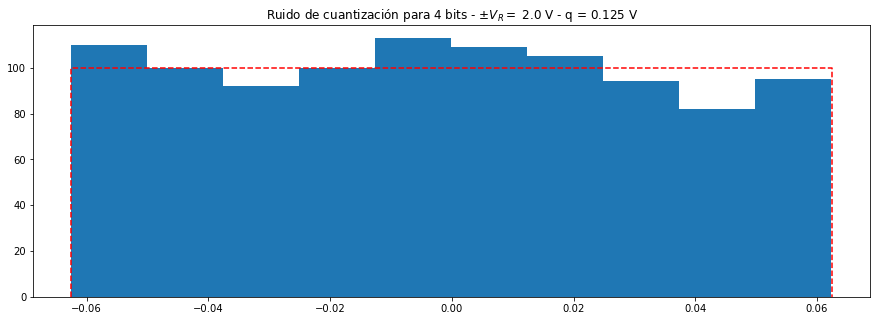

In [37]:
##################################################

plt.figure(3)
bins = 10
plt.hist(Noise_q, bins=bins)
#Aca agregue el 4* ya que no hice mi array de tiempo "discreto" que es 4 veces menor que t
plt.plot( np.array([-q/2, -q/2, q/2, q/2]), np.array([0, N/bins, N/bins, 0]), '--r' )
plt.title( 'Ruido de cuantización para {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q))

plt.show()

## Inciso B)
B=8, k=1

In [38]:
# Datos del ADC
B = 8 # bits
q = Vf/2**B # Volts
 
# datos del ruido
kn = 1
pot_ruido = q**2/12 * kn # Watts (potencia de la señal 1 W)

In [39]:
    #%% Cuentas correspondientes al ruido

##Armo el ruido con la potencia calculada
noise = np.random.normal(0, np.sqrt(pot_ruido), len(seno_ideal_watts))
    #%%Le sumo el ruido al seno ideal
sr_1 = analog_sig + noise

    #%%Cuantizacion
sr=sr_1[::over_sampling]
##Nueva cuantizacion
srq=np.round(sr/q)*q
#%%Normalizo la señal
##Calculo la potencia
E2=1/N*sum(np.abs(srq)**2)

srq_norm=srq/np.sqrt(E2)
#%%Calculo de la Densidad espectral de potencia
DEP_srq=np.abs(1/N*fft(srq_norm))**2
##Calculos del ruido
Noise_q=sr-srq
Noise_q_mean=np.mean(Noise_q)
Noise_mean=np.mean(noise)

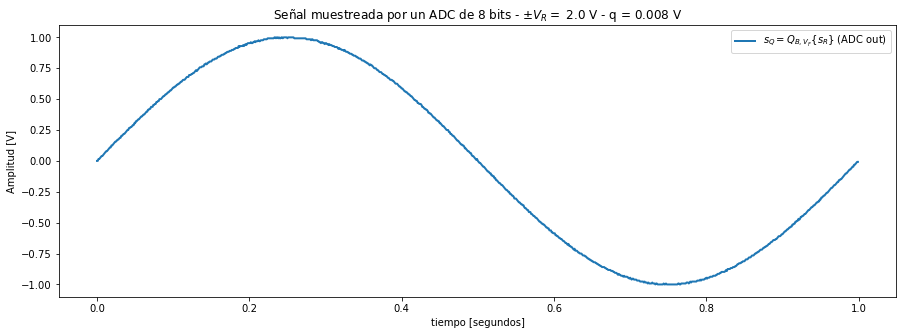

In [40]:
#%% Presentación gráfica de los resultados
plt.close('all')
 
plt.figure(1)
plt.plot(t_samp, srq, lw=2, label='$ s_Q = Q_{B,V_F}\{s_R\} $ (ADC out)')
 
plt.title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q) )
plt.xlabel('tiempo [segundos]')
plt.ylabel('Amplitud [V]')
axes_hdl = plt.gca()
axes_hdl.legend()

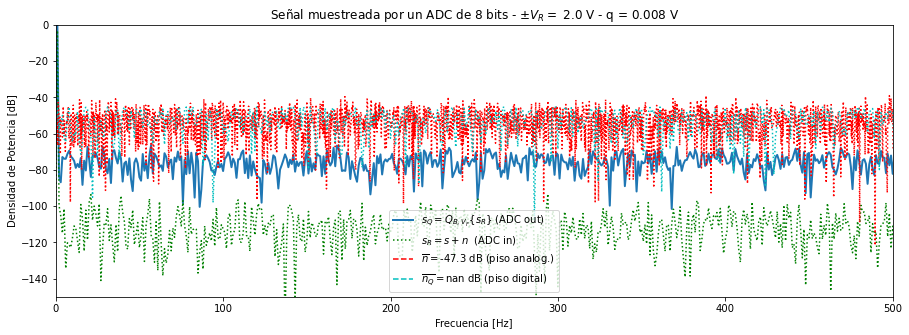

In [41]:
####################################################

plt.figure(2)
plt.plot( f, 10* np.log10(2*DEP_srq), lw=2, label='$ s_Q = Q_{B,V_F}\{s_R\} $ (ADC out)' )
plt.plot( f, 10* np.log10(2*DEP_sr**2), ':g', label='$ s_R = s + n $  (ADC in)' )
plt.plot( f_os, 10* np.log10(2*noise**2), ':r')
plt.plot( f, 10* np.log10(2*Noise_q**2), ':c')
plt.plot( np.array([ 0, 1 ]), 10* np.log10(2* np.array([Noise_mean, Noise_mean]) ), '--r', label= '$ \overline{n} = $' + '{:3.1f} dB (piso analog.)'.format(10* np.log10(2* Noise_mean)) )
plt.plot( np.array([ 0, 1 ]), 10* np.log10(2* np.array([Noise_q_mean, Noise_q_mean]) ), '--c', label='$ \overline{n_Q} = $' + '{:3.1f} dB (piso digital)'.format(10* np.log10(2* Noise_q_mean)) )

plt.title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q) )
plt.ylabel('Densidad de Potencia [dB]')
plt.xlabel('Frecuencia [Hz]')
##Ploteo hasta fs/2 por la paridad
plt.xlim(0,fs/2)
##Enfoco el grafico ya que el seno analogico tiene un piso de ruido muy bajo
plt.ylim(-150,0)
axes_hdl = plt.gca()
axes_hdl.legend()

En el inciso B) se hace obvio en este ultimo grafico como el ruido a la salida de nuestro ADC ficticio disminuye considerablemente respecto del inciso A) con 4 bits